In [1]:
# To see where the company fails or succeeds
# Imbalanced classification problem
# Many features - Regularization required

In [2]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# scikitlearn imports

## Reading the Data

In [22]:
file_path = Path('/home/device1/predictive_ml/datasets/bankruptcy_data.csv')
if file_path.exists() and file_path.suffix == '.csv':
    df = pd.read_csv(file_path)

In [23]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [24]:
# Total number of missing values is 0
int(df.isnull().sum().sum())

0

In [7]:
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [25]:
# The feature/column names should be in lowercase and separated by underscore all the time
column_clean_func = lambda x : x.strip().lower().replace(' ', '_')

df.columns = [column_clean_func(col) for col in df.columns]

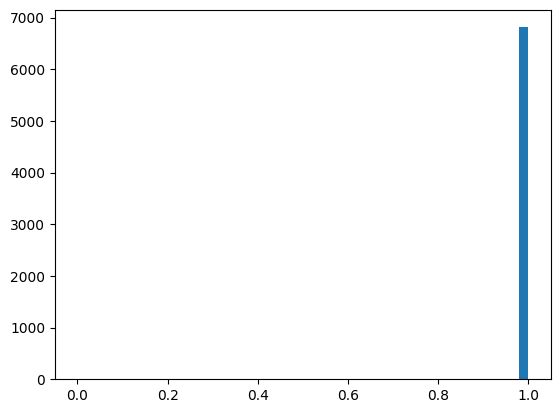

In [11]:
# Not all the columns will be normally distributed
# Operating Profit Rate 
plt.hist(df[' Operating Profit Rate'], bins=50)
plt.show()

## Exploring the Dataset

In [26]:
df.columns[:5]

Index(['bankrupt?', 'roa(c)_before_interest_and_depreciation_before_interest',
       'roa(a)_before_interest_and_%_after_tax',
       'roa(b)_before_interest_and_depreciation_after_tax',
       'operating_gross_margin'],
      dtype='object')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   bankrupt?                                                6819 non-null   int64  
 1   roa(c)_before_interest_and_depreciation_before_interest  6819 non-null   float64
 2   roa(a)_before_interest_and_%_after_tax                   6819 non-null   float64
 3   roa(b)_before_interest_and_depreciation_after_tax        6819 non-null   float64
 4   operating_gross_margin                                   6819 non-null   float64
 5   realized_sales_gross_margin                              6819 non-null   float64
 6   operating_profit_rate                                    6819 non-null   float64
 7   pre-tax_net_interest_rate                                6819 non-null   float64
 8   after-tax_net_interest_rate 

In [43]:
# Lets see if the integer columns are actually n
numerical_cols_int = [col for col in df.columns if df[col].dtype == 'int']
numerical_cols_float = [col for col in df.columns if df[col].dtype=='float']

for col in numerical_cols_int:
    print(f'{col} - Number of unique values : {df[col].nunique()}')

bankrupt? - Number of unique values : 2
liability-assets_flag - Number of unique values : 2
net_income_flag - Number of unique values : 1


### Number of outliers

In [52]:
def calculate_num_outliers(feature_name : str) -> tuple:
    """."""
    try:
        # Calculate the upper and lower limits
        Q1 = df[feature_name].quantile(0.25)
        Q3 = df[feature_name].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        
        # Create arrays of Boolean values indicating the outlier rows
        upper_df = df[df[feature_name] >=upper]
        lower_df = df[df[feature_name] <=lower]
        # upper_array = np.where(df['bmi'] >= upper)[0]
        # lower_array = np.where(df['bmi'] <= lower)[0]
        num_outliers = upper_df.shape[0] + lower_df.shape[0]
        return 'success', feature_name, num_outliers
        
    except Exception as e:
        return str(e), feature_name, None

def get_feature_wise_outliers():
    """."""
    try:
        outlier_df_data = []
        for col in df.columns:
            if col in numerical_cols_float:
                msg, feature_name, num_outliers = calculate_num_outliers(col)
                outlier_df_data.append([msg, feature_name, num_outliers])
            else:
                pass

        return outlier_df_data
    except Exception as e:
        print(str(e))

outlier_df_data = get_feature_wise_outliers()

In [69]:
outlier_df = pd.DataFrame(outlier_df_data, columns = ['msg', 'feature_name', 'num_outliers'])
outlier_df.drop(columns=['msg'], inplace=True)
outlier_df['outlier_percentage'] = round(outlier_df['num_outliers'] / df.shape[0] * 100, 2)

In [107]:
# Most features have outliers which makes different outlier techniques essential
outlier_df.sort_values('outlier_percentage').reset_index(drop = True)[:20]

,feature_name,num_outliers,outlier_percentage
0,operating_expense_rate,0,0.00
1,inventory_turnover_rate_(times),0,0.00
2,current_assets/total_assets,0,0.00
3,quick_asset_turnover_rate,0,0.00
4,cash_turnover_rate,0,0.00
5,quick_assets/total_assets,2,0.03
6,net_worth/assets,30,0.44
7,debt_ratio_%,30,0.44
8,current_liabilities/liability,40,0.59
9,current_liability_to_liability,40,0.59


In [95]:
df.describe()

,bankrupt?,roa(c)_before_interest_and_depreciation_before_interest,roa(a)_before_interest_and_%_after_tax,roa(b)_before_interest_and_depreciation_after_tax,operating_gross_margin,realized_sales_gross_margin,operating_profit_rate,pre-tax_net_interest_rate,after-tax_net_interest_rate,non-industry_income_and_expenditure/revenue,continuous_interest_rate_(after_tax),operating_expense_rate,research_and_development_expense_rate,cash_flow_rate,interest-bearing_debt_interest_rate,tax_rate_(a),net_value_per_share_(b),net_value_per_share_(a),net_value_per_share_(c),persistent_eps_in_the_last_four_seasons,cash_flow_per_share,revenue_per_share_(yuan_¥),operating_profit_per_share_(yuan_¥),per_share_net_profit_before_tax_(yuan_¥),realized_sales_gross_profit_growth_rate,operating_profit_growth_rate,after-tax_net_profit_growth_rate,regular_net_profit_growth_rate,continuous_net_profit_growth_rate,total_asset_growth_rate,net_value_growth_rate,total_asset_return_growth_rate_ratio,cash_reinvestment_%,current_ratio,quick_ratio,interest_expense_ratio,total_debt/total_net_worth,debt_ratio_%,net_worth/assets,long-term_fund_suitability_ratio_(a),borrowing_dependency,contingent_liabilities/net_worth,operating_profit/paid-in_capital,net_profit_before_tax/paid-in_capital,inventory_and_accounts_receivable/net_value,total_asset_turnover,accounts_receivable_turnover,average_collection_days,inventory_turnover_rate_(times),fixed_assets_turnover_frequency,net_worth_turnover_rate_(times),revenue_per_person,operating_profit_per_person,allocation_rate_per_person,working_capital_to_total_assets,quick_assets/total_assets,current_assets/total_assets,cash/total_assets,quick_assets/current_liability,cash/current_liability,current_liability_to_assets,operating_funds_to_liability,inventory/working_capital,inventory/current_liability,current_liabilities/liability,working_capital/equity,current_liabilities/equity,long-term_liability_to_current_assets,retained_earnings_to_total_assets,total_income/total_expense,total_expense/assets,current_asset_turnover_rate,quick_asset_turnover_rate,working_capitcal_turnover_rate,cash_turnover_rate,cash_flow_to_sales,fixed_assets_to_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long-term_liability,cash_flow_to_total_assets,cash_flow_to_liability,cfo_to_assets,cash_flow_to_equity,current_liability_to_current_assets,liability-assets_flag,net_income_to_total_assets,total_assets_to_gnp_price,no-credit_interval,gross_profit_to_sales,net_income_to_stockholder's_equity,liability_to_equity,degree_of_financial_leverage_(dfl),interest_coverage_ratio_(interest_expense_to_ebit),net_income_flag,equity_to_liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [133]:
# check max values of this dataset 
# They should all be 1
# No feature should be more than 1 
def check_min_max_values() -> tuple:
    """."""
    try:
        min_max_scaled_cols_true = []
        min_max_scaled_cols_false = []
        df_describe_stats = df.describe().copy()
        df_describe_stats = df.describe().copy()
        flag_min_max = 1
        for col in df_describe_stats:
            min = df_describe_stats[col]['min']
            max = df_describe_stats[col]['max']
            if min!=0.0 or max!=1.0:
                flag_min_max = 0
                min_max_scaled_cols_false.append(col)
            elif min==0.0 and max==0.0:
                min_max_scaled_cols_true.append(col)

        return 'success', min_max_scaled_cols_true, min_max_scaled_cols_false
    
    except Exception as e:
        return str(e), None, None
    
# float(df.describe().operating_profit_rate['max'])

In [134]:
msg, min_max_scaled_cols_true, min_max_scaled_cols_false = check_min_max_values()
if msg!= 'success':
    print(msg)
else:
    print(min_max_scaled_cols_false)

['operating_expense_rate', 'research_and_development_expense_rate', 'interest-bearing_debt_interest_rate', 'revenue_per_share_(yuan_¥)', 'total_asset_growth_rate', 'net_value_growth_rate', 'current_ratio', 'quick_ratio', 'total_debt/total_net_worth', 'accounts_receivable_turnover', 'average_collection_days', 'inventory_turnover_rate_(times)', 'fixed_assets_turnover_frequency', 'revenue_per_person', 'allocation_rate_per_person', 'quick_assets/current_liability', 'cash/current_liability', 'inventory/current_liability', 'long-term_liability_to_current_assets', 'current_asset_turnover_rate', 'quick_asset_turnover_rate', 'cash_turnover_rate', 'fixed_assets_to_assets', 'total_assets_to_gnp_price', 'net_income_flag']


In [135]:
df.head()

,bankrupt?,roa(c)_before_interest_and_depreciation_before_interest,roa(a)_before_interest_and_%_after_tax,roa(b)_before_interest_and_depreciation_after_tax,operating_gross_margin,realized_sales_gross_margin,operating_profit_rate,pre-tax_net_interest_rate,after-tax_net_interest_rate,non-industry_income_and_expenditure/revenue,continuous_interest_rate_(after_tax),operating_expense_rate,research_and_development_expense_rate,cash_flow_rate,interest-bearing_debt_interest_rate,tax_rate_(a),net_value_per_share_(b),net_value_per_share_(a),net_value_per_share_(c),persistent_eps_in_the_last_four_seasons,cash_flow_per_share,revenue_per_share_(yuan_¥),operating_profit_per_share_(yuan_¥),per_share_net_profit_before_tax_(yuan_¥),realized_sales_gross_profit_growth_rate,operating_profit_growth_rate,after-tax_net_profit_growth_rate,regular_net_profit_growth_rate,continuous_net_profit_growth_rate,total_asset_growth_rate,net_value_growth_rate,total_asset_return_growth_rate_ratio,cash_reinvestment_%,current_ratio,quick_ratio,interest_expense_ratio,total_debt/total_net_worth,debt_ratio_%,net_worth/assets,long-term_fund_suitability_ratio_(a),borrowing_dependency,contingent_liabilities/net_worth,operating_profit/paid-in_capital,net_profit_before_tax/paid-in_capital,inventory_and_accounts_receivable/net_value,total_asset_turnover,accounts_receivable_turnover,average_collection_days,inventory_turnover_rate_(times),fixed_assets_turnover_frequency,net_worth_turnover_rate_(times),revenue_per_person,operating_profit_per_person,allocation_rate_per_person,working_capital_to_total_assets,quick_assets/total_assets,current_assets/total_assets,cash/total_assets,quick_assets/current_liability,cash/current_liability,current_liability_to_assets,operating_funds_to_liability,inventory/working_capital,inventory/current_liability,current_liabilities/liability,working_capital/equity,current_liabilities/equity,long-term_liability_to_current_assets,retained_earnings_to_total_assets,total_income/total_expense,total_expense/assets,current_asset_turnover_rate,quick_asset_turnover_rate,working_capitcal_turnover_rate,cash_turnover_rate,cash_flow_to_sales,fixed_assets_to_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long-term_liability,cash_flow_to_total_assets,cash_flow_to_liability,cfo_to_assets,cash_flow_to_equity,current_liability_to_current_assets,liability-assets_flag,net_income_to_total_assets,total_assets_to_gnp_price,no-credit_interval,gross_profit_to_sales,net_income_to_stockholder's_equity,liability_to_equity,degree_of_financial_leverage_(dfl),interest_coverage_ratio_(interest_expense_to_ebit),net_income_flag,equity_to_liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

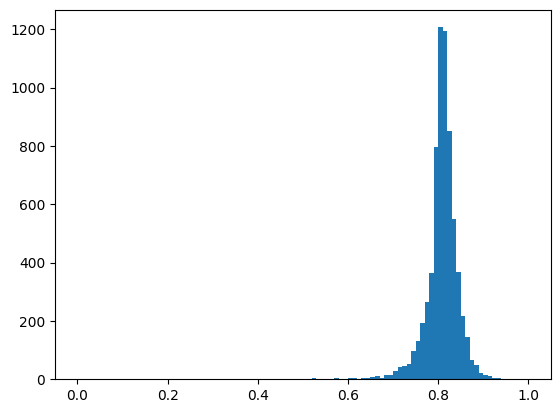

In [139]:
plt.hist(df['net_income_to_total_assets'], bins = 100)
plt.show()

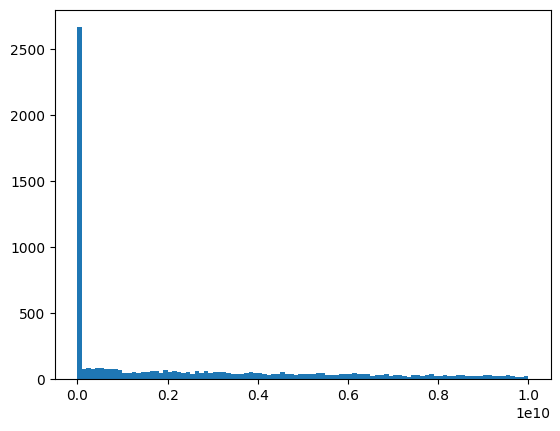

In [138]:
plt.hist(df['cash_turnover_rate'], bins = 100)
plt.show()

In [126]:
df.describe()['average_collection_days']

count    6.819000e+03
mean     9.826221e+06
std      2.563589e+08
min      0.000000e+00
25%      4.386530e-03
50%      6.572537e-03
75%      8.972876e-03
max      9.730000e+09
Name: average_collection_days, dtype: float64

In [121]:
df.describe()['operating_expense_rate']

count    6.819000e+03
mean     1.995347e+09
std      3.237684e+09
min      0.000000e+00
25%      1.566874e-04
50%      2.777589e-04
75%      4.145000e+09
max      9.990000e+09
Name: operating_expense_rate, dtype: float64

In [106]:
df.describe()['bankrupt?']

count    6819.000000
mean        0.032263
std         0.176710
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: bankrupt?, dtype: float64

In [78]:
def find_normally_distributed_features() -> tuple:
    """."""
    try:
        df_describe_stats = df.describe()

    except Exception as e:
        print(str(e))

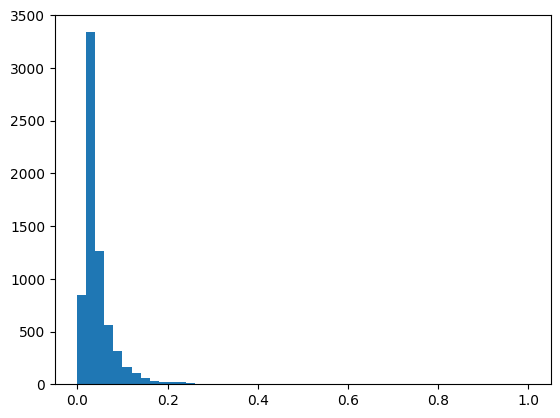

In [17]:
# Right skewed graph
plt.hist(df[' Equity to Liability'], bins=50)
plt.show()

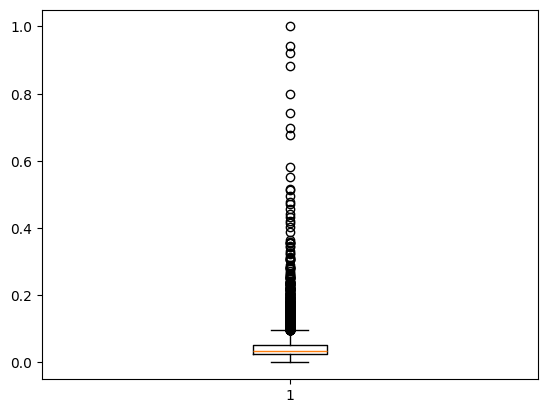

In [18]:

plt.boxplot(df[' Equity to Liability'])
plt.show()